# Lectures 7: Class demo

In [1]:
import os
import sys

sys.path.append("../code/.")

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

## Demo: Model interpretation of linear classifiers

- One of the primary advantages of linear classifiers is their ability to interpret models.
- For instance, by analyzing the sign and magnitude of the learned coefficients, we can address questions regarding which features are influencing the prediction and in which direction.

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. 

In [2]:
imdb_df = pd.read_csv("../data/imdb_master.csv", encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df["label"].str.startswith(("pos", "neg"))]
imdb_df.drop(["Unnamed: 0", "type", "file"], axis=1, inplace=True)
imdb_df.head()

,review,label
0,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the charact...",neg
1,"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and...",neg
2,"First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like clichÃ©'e version of gangst...",neg
3,"Not even the Beatles could write songs everyone liked, and although Walter Hill is no mop-top he's second to none when it comes to thought provoking action movies. The nineties came and social pla...",neg
4,Brass pictures (movies is not a fitting word for them) really are somewhat brassy. Their alluring visual qualities are reminiscent of expensive high class TV commercials. But unfortunately Brass p...,neg


Let's clean up the data a bit. 

In [3]:
import re

def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub("https://\S*", "", doc)
    return doc

In [4]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

Are we breaking the Golden rule here? 

Let's split the data and create bag of words representation. 

In [8]:
# imdb_df

In [5]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["label"]
X_test, y_test = test_df["review_pp"], test_df["label"]
train_df.shape

(5000, 3)

In [11]:
X_train

47278    Best animated movie ever made. This film explores not only the vast world of modern animation with absolutely boggling effects, but the branches of the human mind, soul, and philosophy. The story ...
19664    This film does for Infantry what Das Boot did for Submariners. If you appreciated Das Boot then that is all you really need to know.  This is a well done piece of cinema. On a par with Das Boot. B...
22648    New Yorkers contemporaneous with this film will recall how reflective of its time it is and how well cast and crew captured America, New York City of that era.  Norman Wexler's script delineates t...
33662    Well, you might not actually SEE any women in love in this movie, but you'll certainly hear women TALKING about love, and men talking about love, and women talking about men, and men talking about...
31230    Well I just gave away 95 minutes and 47 seconds that I'll never get back on this piece of trash. I heard someone online describe this movie's villains as "

Is there any missing data?

In [9]:
train_df.isna().sum()

review       0
label        0
review_pp    0
dtype: int64

There is no missing data. We don't need imputation. 

In [12]:
# Let's try CountVectorizer
vec = CountVectorizer(max_features=10_000, stop_words="english")
bow = vec.fit_transform(X_train)
bow

<5000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 383702 stored elements in Compressed Sparse Row format>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names()` on the `CountVectorizer` object. 

In [13]:
vocab = vec.get_feature_names_out()

In [14]:
vocab[0:10]  # first few words

array(['00', '000', '01', '10', '100', '1000', '101', '11', '12', '13'],
      dtype=object)

In [15]:
vocab[2000:2010]  # some middle words

array(['conrad', 'cons', 'conscience', 'conscious', 'consciously',
       'consciousness', 'consequence', 'consequences', 'conservative',
       'conservatory'], dtype=object)

In [16]:
vocab[::500]  # words with a step of 500

array(['00', 'announcement', 'bird', 'cell', 'conrad', 'depth', 'elite',
       'finnish', 'grimy', 'illusions', 'kerr', 'maltin', 'narrates',
       'patients', 'publicity', 'reynolds', 'sfx', 'starting', 'thats',
       'vance'], dtype=object)

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [17]:
dummy = DummyClassifier()
cross_val_score(dummy, X_train, y_train).mean()

0.505

We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [20]:
# Create a pipeline with CountVectorizer and LogisticRegression 
pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000)
                       )
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.565650,0.089532,0.847,1.0
1,0.559551,0.090067,0.832,1.0
2,0.567217,0.089832,0.842,1.0
3,0.551019,0.086508,0.853,1.0
4,0.555996,0.088366,0.839,1.0


Seems like we are overfitting. Let's optimize the hyperparameter `C`. 

In [21]:
scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C=C)
                       )
    scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.001,0.83470,0.7964
1,0.010,0.92265,0.8456
2,0.100,0.98585,0.8520
3,1.000,1.00000,0.8426
4,10.000,1.00000,0.8376
5,100.000,1.00000,0.8350


In [22]:
optimized_C = results_df["C"].iloc[np.argmax(results_df["mean_cv_scores"])]
print(
    "The maximum validation score is %0.3f at C = %0.2f "
    % (
        np.max(results_df["mean_cv_scores"]),
        optimized_C,
    )
)

The maximum validation score is 0.852 at C = 0.10 


Let's train a model on the full training set with the optimized hyperparameter values. 

In [25]:
pipe_lr = make_pipeline(CountVectorizer(max_features=10000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C = 0.10)
                       )
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [26]:
feature_names = np.array(pipe_lr.named_steps["countvectorizer"].get_feature_names_out())
coeffs = pipe_lr.named_steps["logisticregression"].coef_.flatten()

In [27]:
# feature_names

In [28]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,-0.074949
000,-0.083893
01,-0.034402
10,0.056493
100,0.041633
...,...
zoom,-0.013299
zooms,-0.022139
zorak,0.021878
zorro,0.130075


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [29]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.903484
great,0.659922
amazing,0.653301
wonderful,0.651763
favorite,0.607887
...,...
terrible,-0.621695
boring,-0.701030
bad,-0.736608
waste,-0.799353


- The coefficients make sense!

Let's visualize the top 20 features.

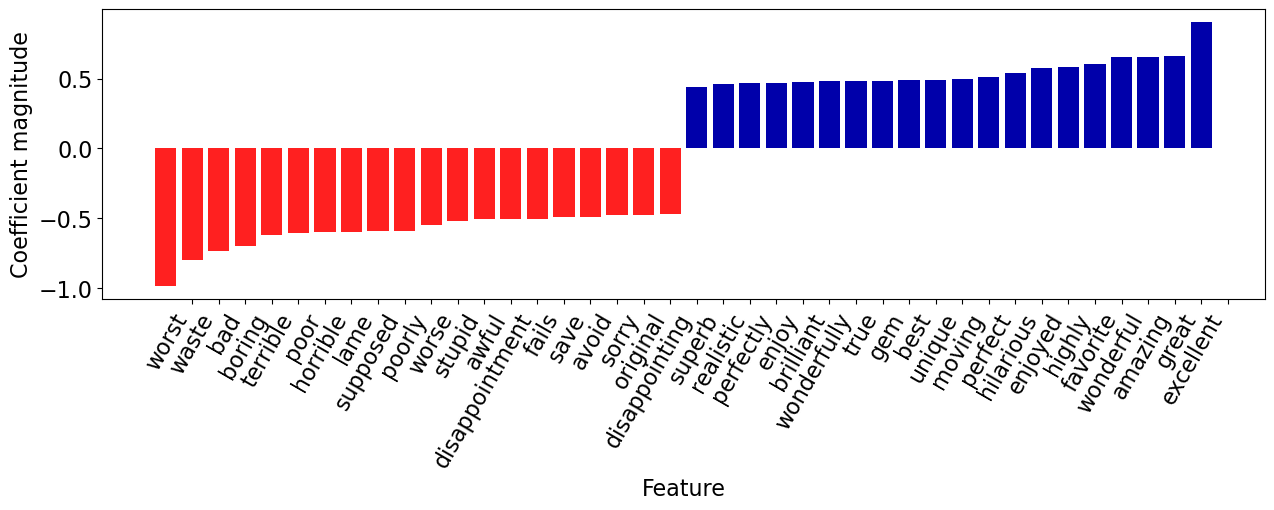

In [30]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=20)

Let's explore prediction of the following new review. 

In [ ]:
# fake_review = "It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!"

In [ ]:
# feat_vec = pipe_lr.named_steps["countvectorizer"].transform([fake_review])

In [ ]:
# feat_vec

Let's get prediction probability scores of the fake review. 

In [ ]:
# pipe_lr.predict_proba([fake_review])

In [ ]:
# pipe_lr.classes_

The model is 83.5% confident that it's a positive review. 

In [ ]:
# pipe_lr.predict([fake_review])[0]

We can find which of the vocabulary words are present in this review:

In [ ]:
# feat_vec.toarray().ravel().astype(bool)

In [ ]:
# words_in_ex = feat_vec.toarray().ravel().astype(bool)
# words_in_ex

How many of the words are in this review?

In [ ]:
# np.sum(words_in_ex)

In [ ]:
# np.array(feature_names)[words_in_ex]

In [ ]:
# ex_df = pd.DataFrame(
#     data=coeffs[words_in_ex],
#     index=np.array(feature_names)[words_in_ex],
#     columns=["Coefficient"],
# )
# ex_df

Let's visualize how the words with positive and negative coefficients are driving the prediction. 

In [ ]:
# mglearn.tools.visualize_coefficients(
#     coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=6
# )

In [ ]:
# def plot_coeff_example(feat_vect, coeffs, feature_names):
#     words_in_ex = feat_vec.toarray().ravel().astype(bool)

#     ex_df = pd.DataFrame(
#         data=coeffs[words_in_ex],
#         index=np.array(feature_names)[words_in_ex],
#         columns=["Coefficient"],
#     )
#     return ex_df

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the reviews where our classifier is most confident or least confident?

In [ ]:
# pos_probs = pipe_lr.predict_proba(X_train)[
#     :, 1
# ]  # only get probabilities associated with pos class
# pos_probs

Let's get the index of the example where the classifier is most confident (highest `predict_proba` score for positive). 

In [ ]:
# most_positive = np.argmax(pos_probs)

In [ ]:
# X_train.iloc[most_positive]

In [ ]:
# print("True target: %s\n" % (y_train.iloc[most_positive]))
# print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_positive]])[0]))
# print("Prediction probability: %0.4f" % (pos_probs[most_positive]))

Let's examine the features associated with the review. 

In [ ]:
# feat_vec = pipe_lr.named_steps["countvectorizer"].transform(
#     X_train.iloc[[most_positive]]
# )
# words_in_ex = feat_vec.toarray().ravel().astype(bool)
# mglearn.tools.visualize_coefficients(
#     coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=20
# )

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [ ]:
# neg_probs = pipe_lr.predict_proba(X_train)[
#     :, 0
# ]  # only get probabilities associated with pos class
# neg_probs

In [ ]:
# most_negative = np.argmax(neg_probs)

In [ ]:
# print("Review: %s\n" % (X_train.iloc[[most_negative]]))
# print("True target: %s\n" % (y_train.iloc[most_negative]))
# print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_negative]])[0]))
# print("Prediction probability: %0.4f" % (pos_probs[most_negative]))

In [ ]:
# feat_vec = pipe_lr.named_steps["countvectorizer"].transform(
#     X_train.iloc[[most_negative]]
# )
# words_in_ex = feat_vec.toarray().ravel().astype(bool)
# mglearn.tools.visualize_coefficients(
#     coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=20
# )

The review has both positive and negative words but the words with negative coefficients win in this case! 

## ❓❓ Questions for you

#### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  
